In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자처럼/DataThon/dataset/Moulding/"
SEED = 42

In [4]:
train = pd.read_csv(f"{DATA_PATH}train_set.csv")
test = pd.read_csv(f"{DATA_PATH}test_set.csv")
unlabeled = pd.read_csv(f"{DATA_PATH}unlabeled_data.csv")

train.shape, test.shape, unlabeled.shape

((4707, 45), (523, 45), (795315, 46))

In [11]:
unlabeled = unlabeled.drop("Unnamed: 0", axis=1)
unlabeled.shape

(795315, 45)

# Labeled EDA

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4707 entries, 0 to 4706
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       4707 non-null   object 
 1   TimeStamp                 4707 non-null   object 
 2   PART_FACT_PLAN_DATE       4707 non-null   object 
 3   PART_FACT_SERIAL          4707 non-null   int64  
 4   PART_NAME                 4707 non-null   object 
 5   EQUIP_CD                  4707 non-null   object 
 6   EQUIP_NAME                4707 non-null   object 
 7   PassOrFail                4707 non-null   object 
 8   Reason                    54 non-null     object 
 9   Injection_Time            4707 non-null   float64
 10  Filling_Time              4707 non-null   float64
 11  Plasticizing_Time         4707 non-null   float64
 12  Cycle_Time                4707 non-null   float64
 13  Clamp_Close_Time          4707 non-null   float64
 14  Cushion_

In [38]:
# Reason -> 결측치 존재
train.isnull().sum().sum(), test.isnull().sum().sum()

(4653, 517)

In [16]:
train.iloc[:, 0:15].describe()

,PART_FACT_SERIAL,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position
count,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000
mean,11.814532,7.503824,3.593720,15.894988,60.080705,7.040102,653.633679
std,5.019323,3.653406,1.508945,1.694423,0.994145,0.144937,0.360080
min,4.000000,1.050000,0.930000,12.800000,58.840000,6.070000,653.390015
25%,9.000000,9.500000,4.380000,16.530001,59.520000,7.110000,653.429993
50%,10.000000,9.540000,4.430000,16.799999,59.520000,7.120000,653.440002
75%,13.000000,9.580000,4.470000,16.915000,59.900002,7.120000,653.460022
max,24.000000,13.390000,8.270000,21.100000,64.349998,7.180000,655.000000


In [42]:
# Switch_Over_Position, Clamp_Open_Position 분포가 조금 극단적인 모습을 보임 -> 확인 필요
train.iloc[:, 15:25].describe()

,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Switch_Over_Pressure,Max_Back_Pressure,Average_Back_Pressure
count,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000
mean,0.556881,64.818290,490.151871,73.223752,30.732271,181.619312,142.163438,131.624835,42.314319,59.790142
std,19.097047,6.382806,276.684422,31.144926,0.148264,129.557370,1.410492,8.648345,7.957415,2.593812
min,0.000000,53.549999,4.630000,38.500000,30.299999,29.000000,140.699997,109.699997,21.700001,13.300000
25%,0.000000,68.239998,647.989990,55.299999,30.600000,29.200001,141.800003,135.699997,37.700001,59.400002
50%,0.000000,68.339996,647.989990,55.799999,30.700001,290.500000,142.000000,136.399994,38.099998,59.700001
75%,0.000000,68.489998,647.989990,56.450001,30.799999,292.500000,142.199997,136.699997,38.700001,60.099998
max,655.309998,68.860001,647.989990,128.500000,31.200001,293.899994,169.100006,146.699997,75.199997,90.800003


In [41]:
# Switch_Over_Position = 고압,보압절환위치(고압(사출압)에서 보압으로 진행될때의 위치)) (mm단위)
train["Switch_Over_Position"].value_counts()

,count
Switch_Over_Position,
0.000000,4703
655.309998,4


In [40]:
# Clamp_Open_Position = 제품이 생산되어 추출하기 위해 금형이 열리고 난 위치
train["Clamp_Open_Position"].value_counts()

,count
Clamp_Open_Position,
647.989990,3551
4.630000,1144
69.639999,12


In [39]:
# Average_Screw_RPM = 사출을 위한 스크류 평균 속도
train["Average_Screw_RPM"].value_counts()

,count
Average_Screw_RPM,
29.200001,1897
292.500000,1064
290.500000,631
292.399994,398
290.600006,331
292.600006,160
290.399994,86
29.000000,65
290.700012,31


In [25]:
# Barrel_Temperature_7 => 확인 필요
train.iloc[:, 25:35].describe()

,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Barrel_Temperature_7,Hopper_Temperature,Mold_Temperature_1,Mold_Temperature_2
count,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.0,4707.000000,4707.0,4707.0
mean,278.440748,277.620225,277.360846,271.559465,257.392989,231.194222,0.0,66.563820,0.0,0.0
std,4.553816,4.499337,4.522606,2.622871,4.393497,2.166989,0.0,2.010552,0.0,0.0
min,244.699997,249.600006,249.600006,244.699997,239.899994,224.600006,0.0,38.500000,0.0,0.0
25%,275.899994,275.100006,274.899994,269.899994,254.899994,229.899994,0.0,65.400002,0.0,0.0
50%,276.299988,275.399994,275.100006,270.899994,255.100006,230.100006,0.0,66.699997,0.0,0.0
75%,277.200012,276.200012,275.700012,272.000000,255.899994,230.500000,0.0,67.599998,0.0,0.0
max,287.100006,286.500000,285.799988,276.799988,266.399994,235.500000,0.0,70.599998,0.0,0.0


In [27]:
train["Barrel_Temperature_7"].value_counts()

,count
Barrel_Temperature_7,
0.0,4707


In [26]:
# Mole_Temperature_3, Mold_Temperature_4 빼고 나머지 다 0
train.iloc[:, 35:].describe()

,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
count,4707.000000,4707.000000,4707.0,4707.0,4707.0,4707.0,4707.0,4707.0,4707.0,4707.0
mean,22.343403,23.727916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.189117,1.442009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,19.200001,20.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,21.500000,22.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,22.200001,23.700001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,23.100000,24.299999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,25.299999,27.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
train["TimeStamp"] = pd.to_datetime(train["TimeStamp"])
test["TimeStamp"] = pd.to_datetime(test["TimeStamp"])

In [29]:
# 정상 : 0, 불량 : 1
train["PassOrFail"] = (train["PassOrFail"]=="N").astype(int)
test["PassOrFail"] = (test["PassOrFail"]=="N").astype(int)

In [30]:
target = train["PassOrFail"]
train_ft = train.drop("PassOrFail", axis=1)
test_target = test["PassOrFail"]
test_ft = test.drop("PassOrFail", axis=1)

train_ft.shape, test_ft.shape, target.shape, test_target.shape

((4707, 44), (523, 44), (4707,), (523,))

# Unlabeled EDA

In [31]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795315 entries, 0 to 795314
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   _id                       795315 non-null  object 
 1   TimeStamp                 795315 non-null  object 
 2   PART_FACT_PLAN_DATE       795315 non-null  object 
 3   PART_FACT_SERIAL          795315 non-null  int64  
 4   PART_NO                   795315 non-null  object 
 5   PART_NAME                 795315 non-null  object 
 6   EQUIP_CD                  795315 non-null  object 
 7   EQUIP_NAME                795315 non-null  object 
 8   ERR_FACT_QTY              795315 non-null  int64  
 9   Injection_Time            795315 non-null  float64
 10  Filling_Time              795315 non-null  float64
 11  Plasticizing_Time         795315 non-null  float64
 12  Cycle_Time                795315 non-null  float64
 13  Clamp_Close_Time          795315 non-null  f

In [52]:
unlabeled.head()

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NO,PART_NAME,EQUIP_CD,EQUIP_NAME,ERR_FACT_QTY,Injection_Time,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f9136166e37704af878240e,2020-01-02 00:59:22,2020-01-02 오전 12:00:00,2,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11,3.18,...,0.0,0.0,0,0,0,0,0,0,0,0
1,5f9136166e37704af878240f,2020-01-02 01:01:01,2020-01-02 오전 12:00:00,1,87275Q5000,"SP2 CVR ROOF RACK CTR, LH",S01,1800TON-우진,11,16.29,...,0.0,0.0,0,0,0,0,0,0,0,0
2,5f9136166e37704af8782410,2020-01-02 01:01:01,2020-01-02 오전 12:00:00,2,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11,16.29,...,0.0,0.0,0,0,0,0,0,0,0,0
3,5f9136166e37704af8782411,2020-01-02 01:02:24,2020-01-02 오전 12:00:00,1,87275Q5000,"SP2 CVR ROOF RACK CTR, LH",S01,1800TON-우진,11,16.28,...,0.0,0.0,0,0,0,0,0,0,0,0
4,5f9136166e37704af8782412,2020-01-02 01:02:24,2020-01-02 오전 12:00:00,2,87285Q5000,"SP2 CVR ROOF RACK CTR, RH",S01,1800TON-우진,11,16.28,...,0.0,0.0,0,0,0,0,0,0,0,0


In [34]:
unlabeled.isnull().sum().sum()

0

In [44]:
unlabeled.iloc[:, :15].describe()

,PART_FACT_SERIAL,ERR_FACT_QTY,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position
count,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000
mean,7.346591,13.862124,9.454754,3.897417,11.230021,58.030807,5.575053,215.040085
std,6.070685,26.549459,5.569126,1.645200,7.619902,16.916262,1.913712,296.933993
min,1.000000,0.000000,0.130000,0.000000,0.200000,0.000000,2.110000,0.000000
25%,2.000000,1.000000,5.000000,2.950000,2.900000,39.100000,3.400000,11.800000
50%,6.000000,5.000000,9.520000,3.350000,10.950000,64.420000,6.080000,18.200000
75%,10.000000,13.000000,16.290000,5.000000,16.770000,67.590000,6.720000,653.620000
max,54.000000,353.000000,29.100000,29.100000,468.200000,648.390000,30.100000,655.330000


In [45]:
unlabeled.iloc[:, 15:25].describe()

,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Switch_Over_Pressure,Max_Back_Pressure,Average_Back_Pressure
count,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000
mean,10.884156,63.556493,561.095939,47.579900,22.219916,104.958686,118.592751,101.215787,15.499801,27.840412
std,19.045073,40.963720,369.229806,27.673404,18.474614,132.135577,34.728643,31.695158,20.118355,28.318217
min,0.000000,31.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
25%,0.000000,40.500000,485.600000,25.700000,0.000000,0.000000,80.700000,70.000000,3.800000,0.000000
50%,10.000000,59.900000,522.500000,38.800000,27.000000,25.500000,131.700000,102.300000,5.200000,22.100000
75%,18.200000,63.420000,883.300000,55.900000,30.700000,290.600000,141.700000,131.900000,17.800000,49.300000
max,655.340000,392.900000,1901.000000,128.800000,106.300000,484.200000,199.900000,6553.100000,121.500000,165.200000


In [46]:
unlabeled.iloc[:, 25:35].describe()

,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Barrel_Temperature_7,Hopper_Temperature,Mold_Temperature_1,Mold_Temperature_2
count,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.000000,795315.0,795315.0
mean,88.723012,262.881242,266.185574,264.326963,257.662214,241.974084,22.456352,38.443004,0.0,0.0
std,124.626114,13.272051,11.712932,11.421668,12.901731,15.345906,15.800926,27.358290,0.0,0.0
min,0.000000,189.400000,189.000000,179.400000,179.600000,167.800000,0.000000,0.000000,0.0,0.0
25%,0.000000,260.400000,264.900000,264.800000,254.800000,230.100000,0.000000,0.000000,0.0,0.0
50%,0.000000,264.800000,269.900000,269.800000,259.900000,239.900000,30.200000,56.700000,0.0,0.0
75%,245.300000,265.900000,270.400000,270.100000,269.800000,259.800000,32.800000,61.600000,0.0,0.0
max,990.200000,340.300000,290.300000,290.100000,290.200000,276.800000,50.500000,75.100000,0.0,0.0


In [49]:
# Mold_Temperature_3, Mold_Temperature_4 빼고는 값이 다 0
unlabeled.iloc[:, 35:].describe()

,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
count,795315.000000,795315.000000,795315.0,795315.0,795315.0,795315.0,795315.0,795315.0,795315.0,795315.0
mean,7.672545,8.939656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,11.476776,13.608882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,20.700000,23.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,39.200000,51.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# 생산시 발생한 불량의 개수 합
unlabeled["ERR_FACT_QTY"].sum()

11024755

In [67]:
# unlabeled["TimeStamp"] = pd.to_datetime(unlabeled["TimeStamp"])
unlabeled["TimeStamp"].describe()

,TimeStamp
count,795315
mean,2020-06-23 16:43:02.748342528
min,2020-01-02 00:59:22
25%,2020-04-17 03:45:14
50%,2020-07-01 14:42:18
75%,2020-08-31 12:03:26.500000
max,2020-10-23 05:31:28


In [77]:
unlabeled["EQUIP_NAME"].unique()

array(['1800TON-우진', '850TON-LS 1호기', '550TON-도시바', '3300TON-우진',
       '850TON-미쓰비시', '240TON-우진', '650톤-우진', '650TON-LS', '2000TON-동신',
       '850TON-LS 2호기', '650톤-우진2호기', '수직사출기', '450TON-LS'], dtype=object)

In [83]:
train["PART_NAME"].unique()

array(["CN7 W/S SIDE MLD'G RH", "CN7 W/S SIDE MLD'G LH",
       "RG3 MOLD'G W/SHLD, RH", "RG3 MOLD'G W/SHLD, LH"], dtype=object)

In [85]:
unlabeled["PART_NAME"].unique()

array(['SP2 CVR ROOF RACK CTR, RH', 'SP2 CVR ROOF RACK CTR, LH',
       'BR2 COVER-ROOF RACK,LH(사출)', 'CD SIDE MOLDING LH',
       'TM SIDE STEP TRIM LH', 'TM SIDE STEP TRIM RH',
       'SIDE-RR BUMPER SINGLE', 'SK3 PAD-ROOF RACK, LH',
       'SK3 SIDE RAIL-ROOF RACK, LH', 'SK3 SIDE RAIL-ROOF RACK, RH',
       'FOR YP SIDE STEP TRIM LH(사출)', 'FOR YP SIDE STEP TRIM RH(사출)',
       'JSN-CVR RR BPR UPR', 'SP2 PAD-ROOF RACK, LH',
       'UM SIDE STEP TRIM RH', 'UM SIDE STEP TRIM LH',
       'ON SIDE STEP PLATE, RH', 'SKID-FRT BUMPER',
       'SP2 CAP-ROOF RACK(사출)', 'BR2 SIDE RAIL-ROOF RACK,LH',
       'BR2 SIDE RAIL-ROOF RACK,RH', 'BR2 PAD-ROOF RACK,LH', 'X61G FRT',
       'SP2 PAD-ROOF RACK, RH', 'CD SIDE MOLDING RH', 'X61G RR',
       'PCV CAP SHELL(Gamma2-T)', 'SIDE-RR BUMPER DUAL',
       'SK3 CAP-ROOF RACK(사출)', "LX2 W/S SIDE MLD'G LH",
       'ON SIDE STEP PLATE, LH', "CD S/B MOLD'G W/S SIDE LH",
       "LX2 W/S SIDE MLD'G RH", 'FLANGE SHELL(Gamma2-T)',
       "JX1 W/S SIDE MLD'G LH

In [79]:
unlabeled["PART_NO"].unique()

array(['87285Q5000', '87275Q5000', '87263R1400', '86133J7000',
       'TM3050L000', 'TM3060R000', 'TM1220B003', '87277K0000',
       '87272K0000', '87282K0000', 'YP5740B000', 'YP5750B000',
       '86611K9000', '87277Q5000', 'UM3060R000', 'UM3050L000',
       'ON-SS1210', 'TM1200B003', '87293Q5000', '87272R1400',
       '87282R1400', '87277R1400', 'XG1000F000-1', '87287Q5000',
       '86134J7000', 'XG1000R000-1', '9163240005', 'TM1210B003',
       '87293K0001', '86131S8000', 'ON-SS1110', '86141J7700',
       '86141S8000', '9163240004', '86131T6000', '87282Q5000',
       '87272Q5000', '86131G3000', '86132G3000', '9163240003',
       'YP3330R000', '86142J7700', '87264R1400', 'TL3080R000',
       'ON-SS1130', '86131T1000', '87287K0000', '86141T6000',
       '86141AA000', '87136T1000', '86141T1000', 'DM3050L000',
       '86131AA000', '87138T1000', '86131G4700', '86132G4700',
       '86141BC300', '86131BC300', '9163240002', '84721G9000',
       'DM3120L000', 'DM3060R000', 'QL3060R000', 'QL30

In [78]:
unlabeled.columns

Index(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
       'PART_NO', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'ERR_FACT_QTY',
       'Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Switch_Over_Position',
       'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed',
       'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Barrel_Temperature_7', 'Hopper_Temperature',
       'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_3',
       'Mold_Temperature_4', 'Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11

# 시각화

In [69]:
train_lst = ["Mold_Temperature_1", "Mold_Temperature_2", "Mold_Temperature_5", "Mold_Temperature_6",
             "Mold_Temperature_7", "Mold_Temperature_8", "Mold_Temperature_9", "Mold_Temperature_10",
             "Mold_Temperature_11", "Mold_Temperature_12", "Barrel_Temperature_7"]

train_viz = train_ft.drop(train_lst, axis=1)

<Axes: >

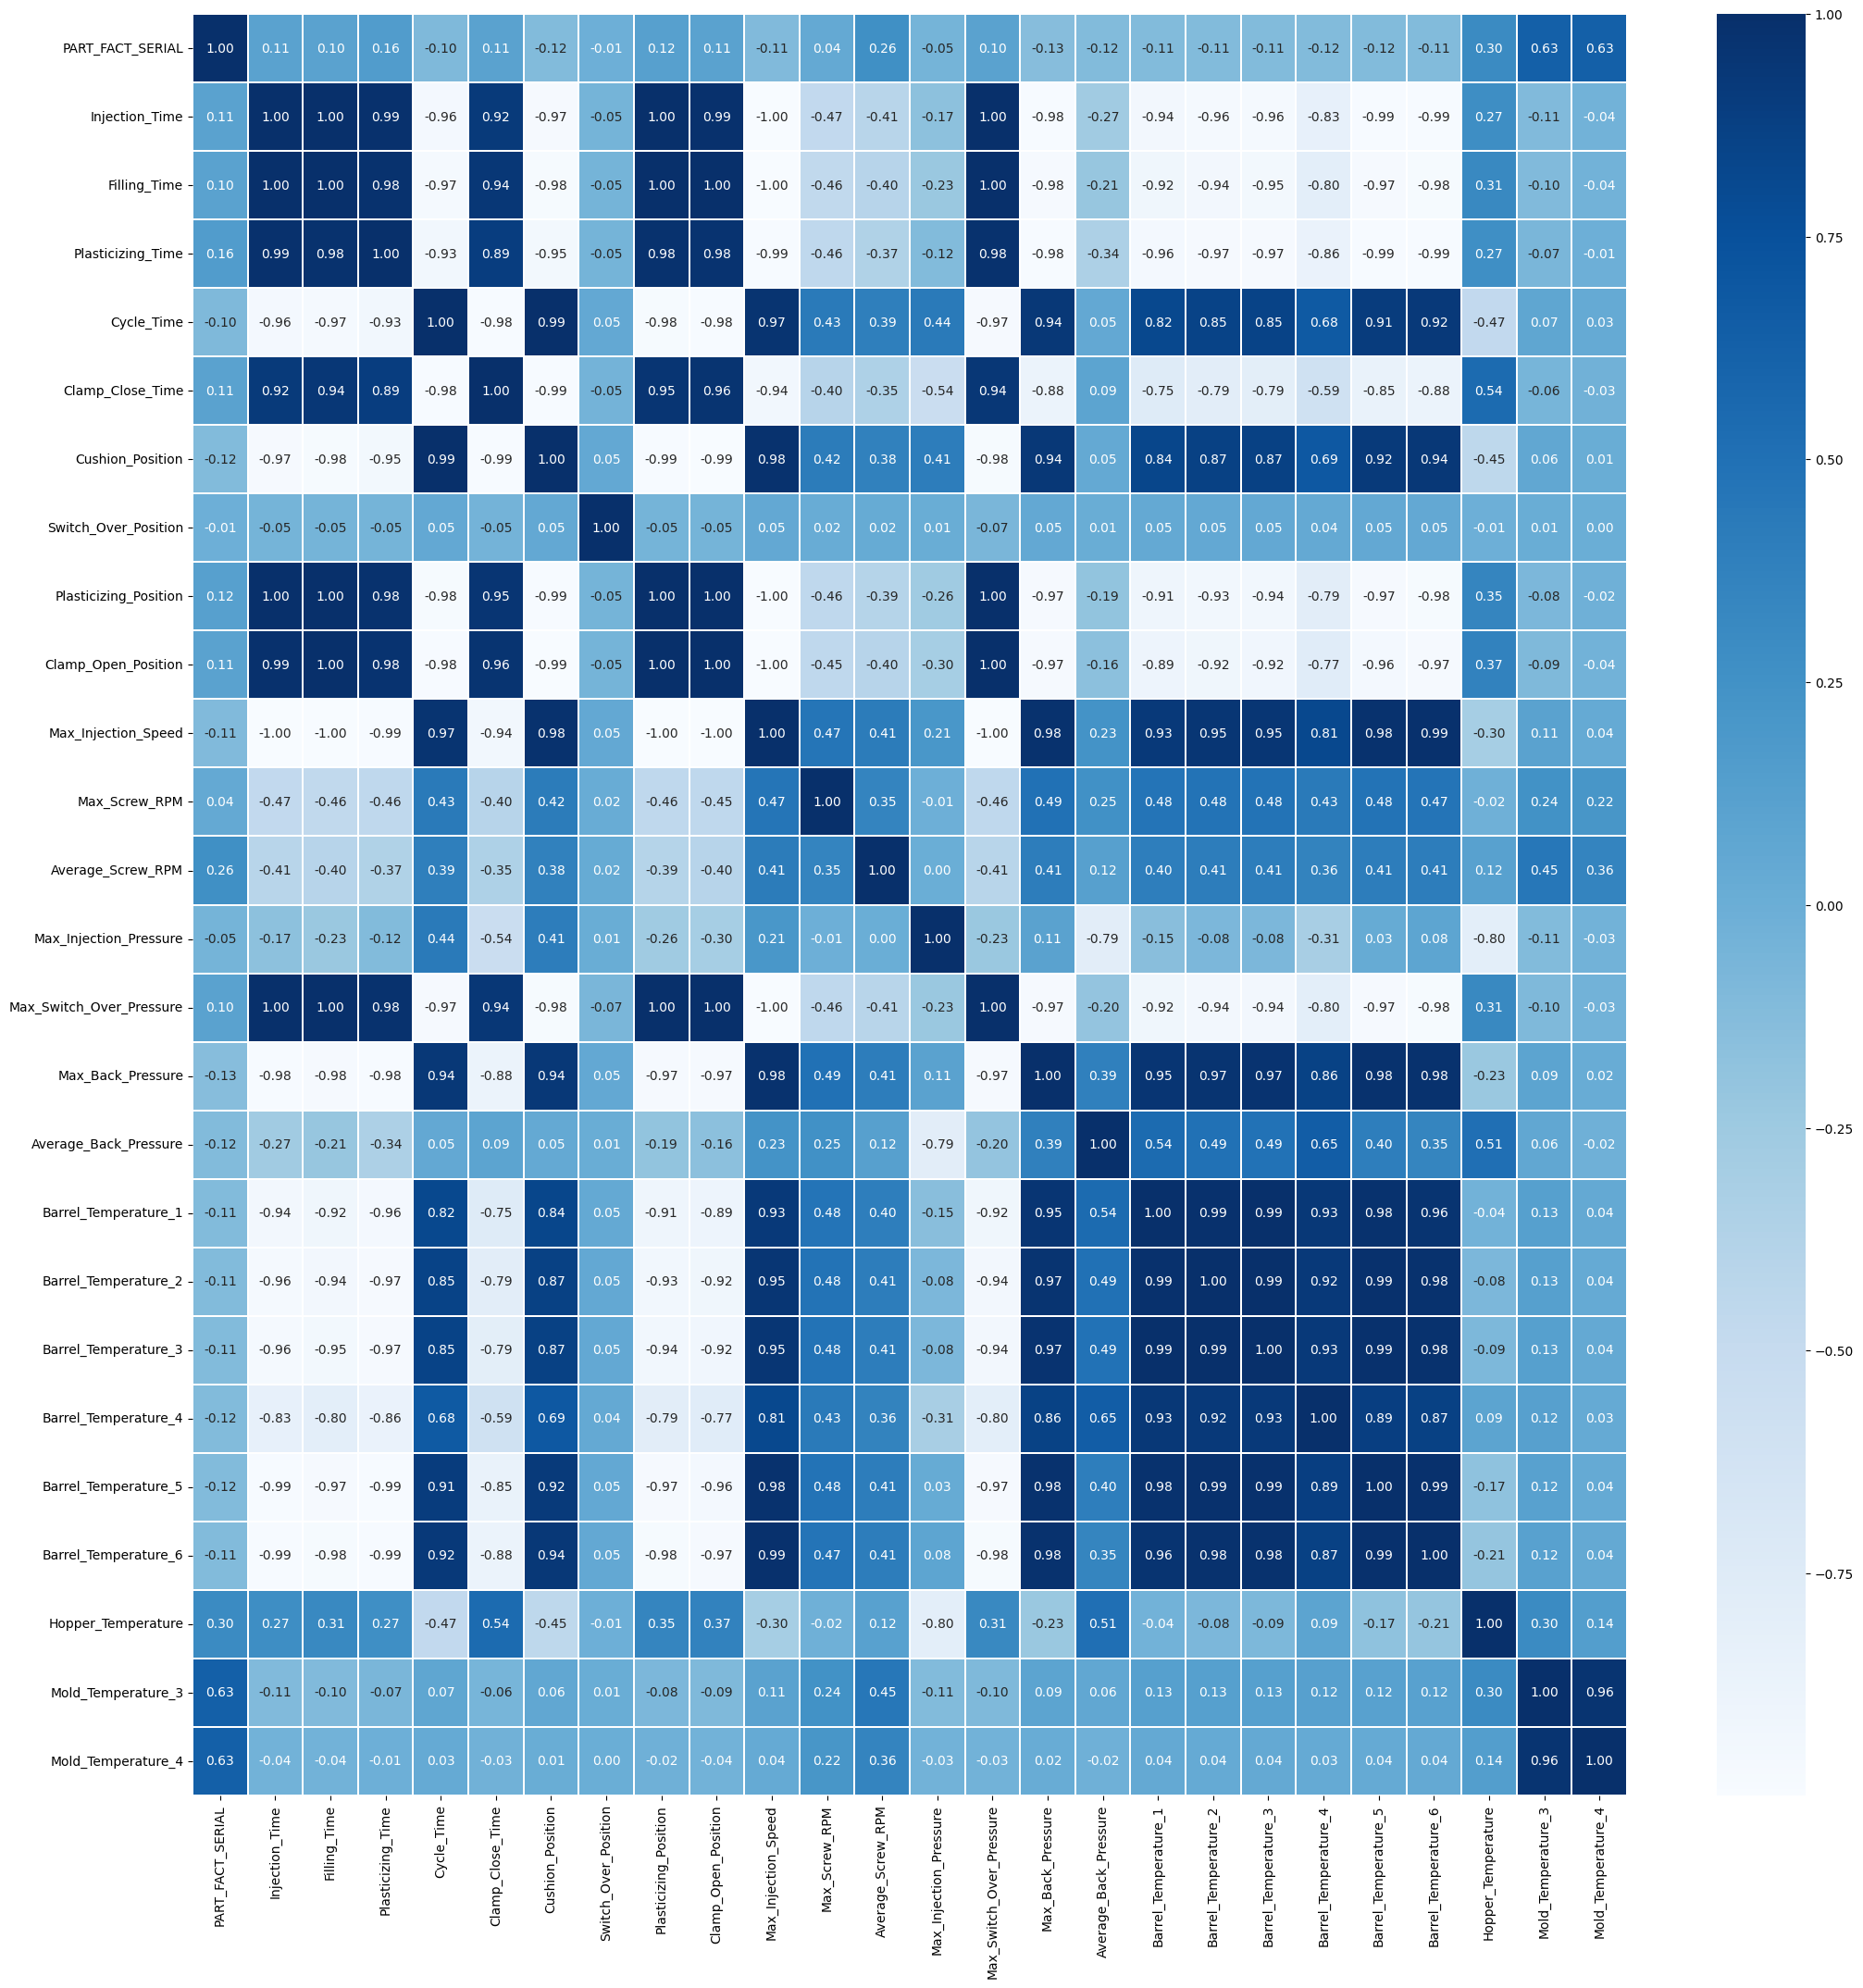

In [70]:
plt.subplots(figsize=(25, 25))
sns.heatmap(train_viz.select_dtypes(include=np.number).corr(),
            linewidths=0.1,
            annot=True,
            fmt=".2f",
            cmap="Blues")

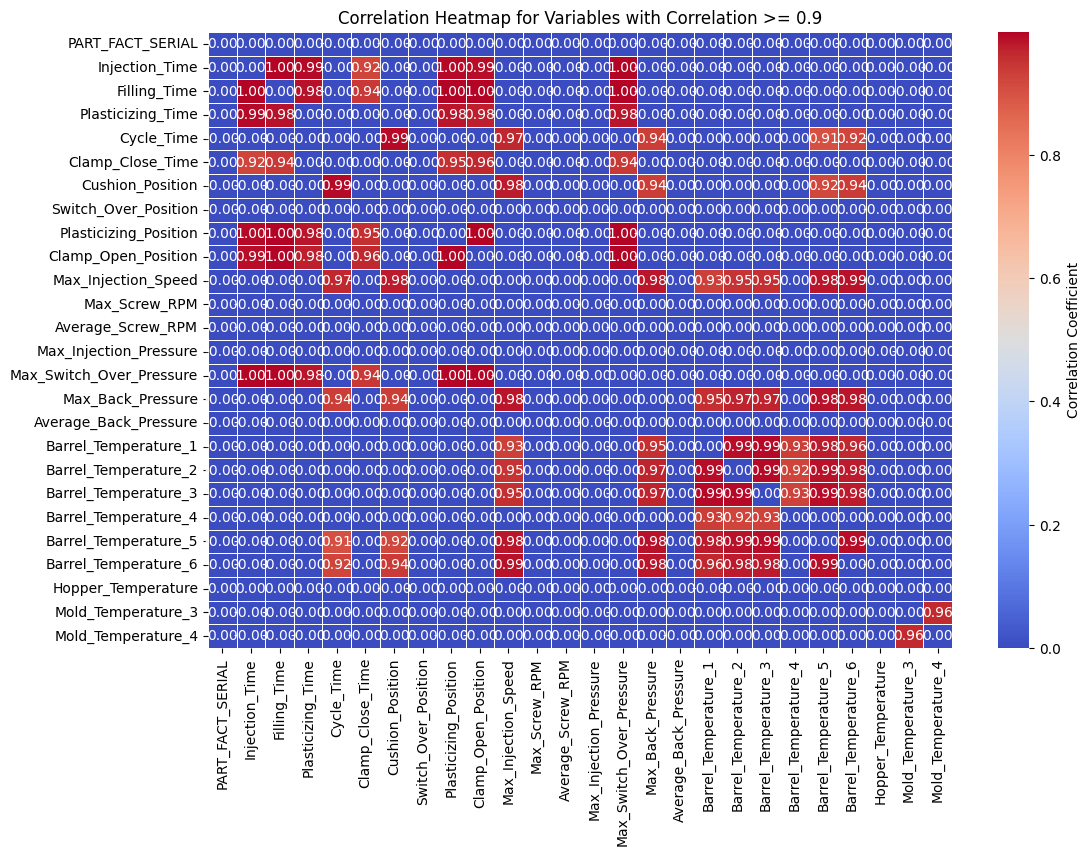

In [74]:
# 전체 상관 행렬 계산
correlation_matrix = train_viz.select_dtypes(include=np.number).corr()

# 상관계수가 0.9 이상인 변수들의 인덱스를 추출
high_corr_mask = (correlation_matrix >= 0.9) & (correlation_matrix != 1)  # 자기 자신 제외

# 높은 상관관계를 가진 변수들만 포함하는 상관 행렬 생성
high_corr_matrix = correlation_matrix * high_corr_mask

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Heatmap for Variables with Correlation >= 0.9")
plt.show()

In [71]:
unlabeld_lst = ["Mold_Temperature_1", "Mold_Temperature_2", "Mold_Temperature_5", "Mold_Temperature_6",
             "Mold_Temperature_7", "Mold_Temperature_8", "Mold_Temperature_9", "Mold_Temperature_10",
             "Mold_Temperature_11", "Mold_Temperature_12"]

unlabeled_viz = unlabeled.drop(train_lst, axis=1)

<Axes: >

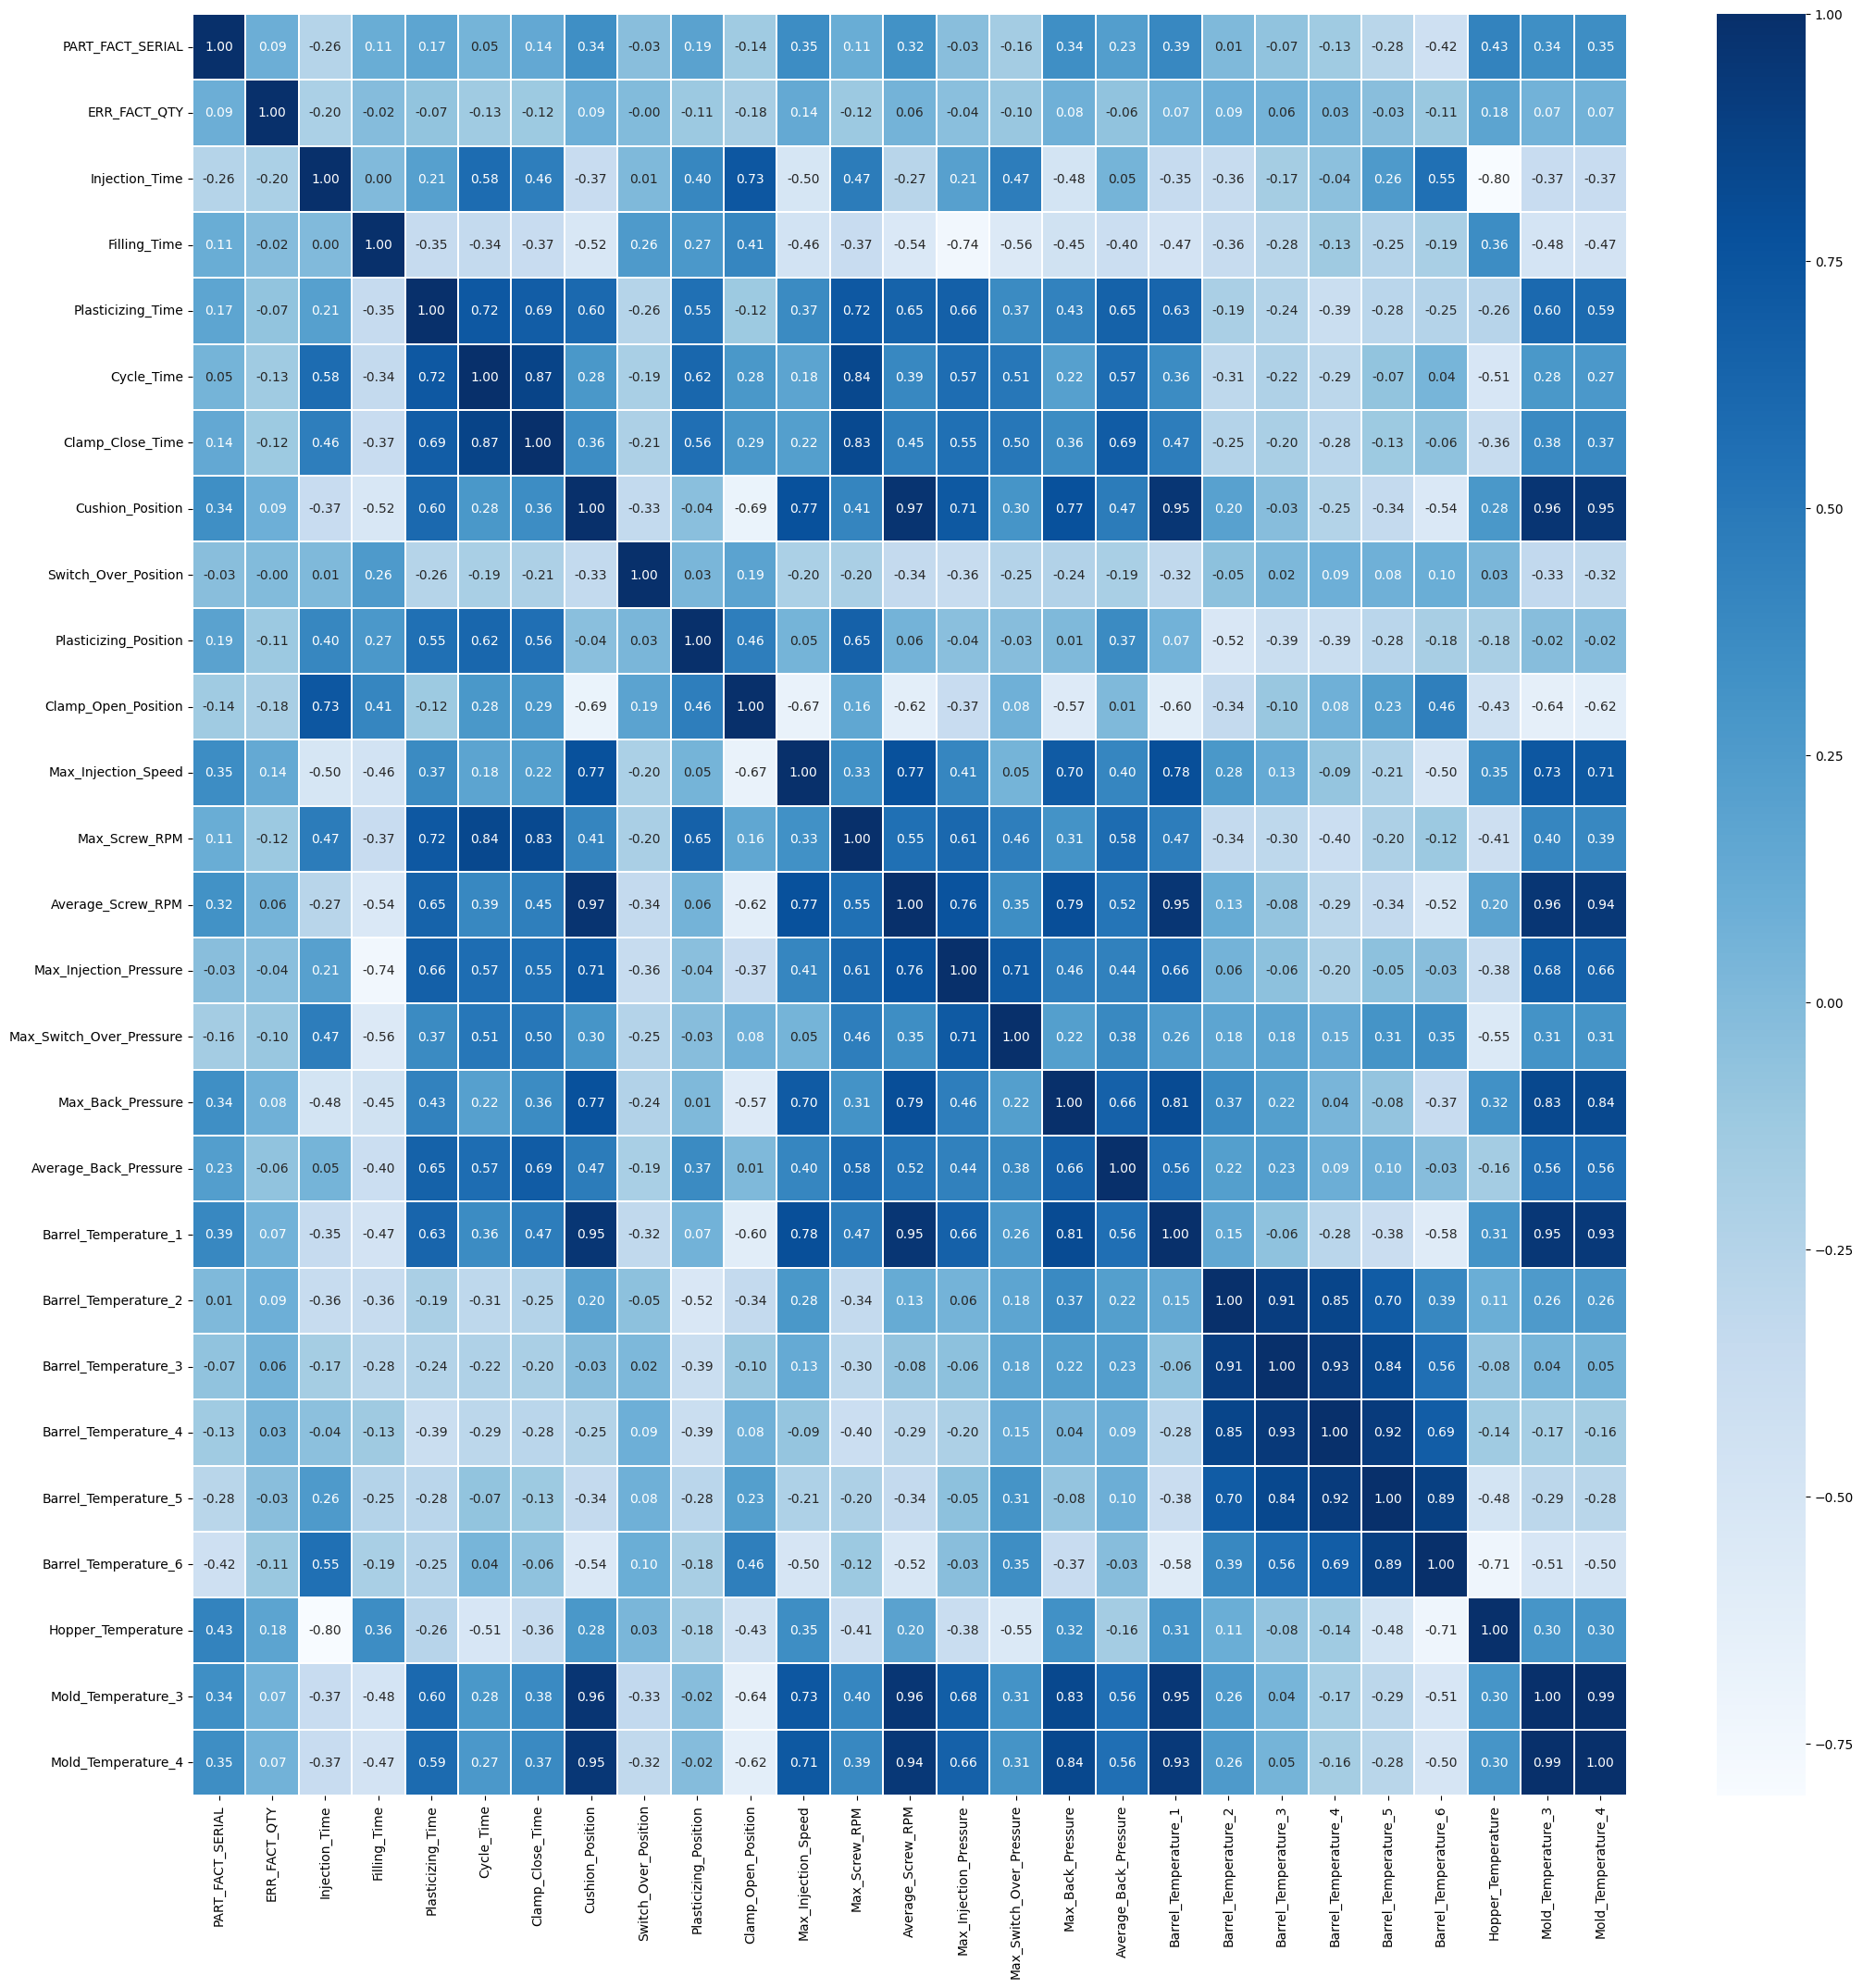

In [72]:
plt.subplots(figsize=(25, 25))
sns.heatmap(unlabeled_viz.select_dtypes(include=np.number).corr(),
            linewidths=0.1,
            annot=True,
            fmt=".2f",
            cmap="Blues")

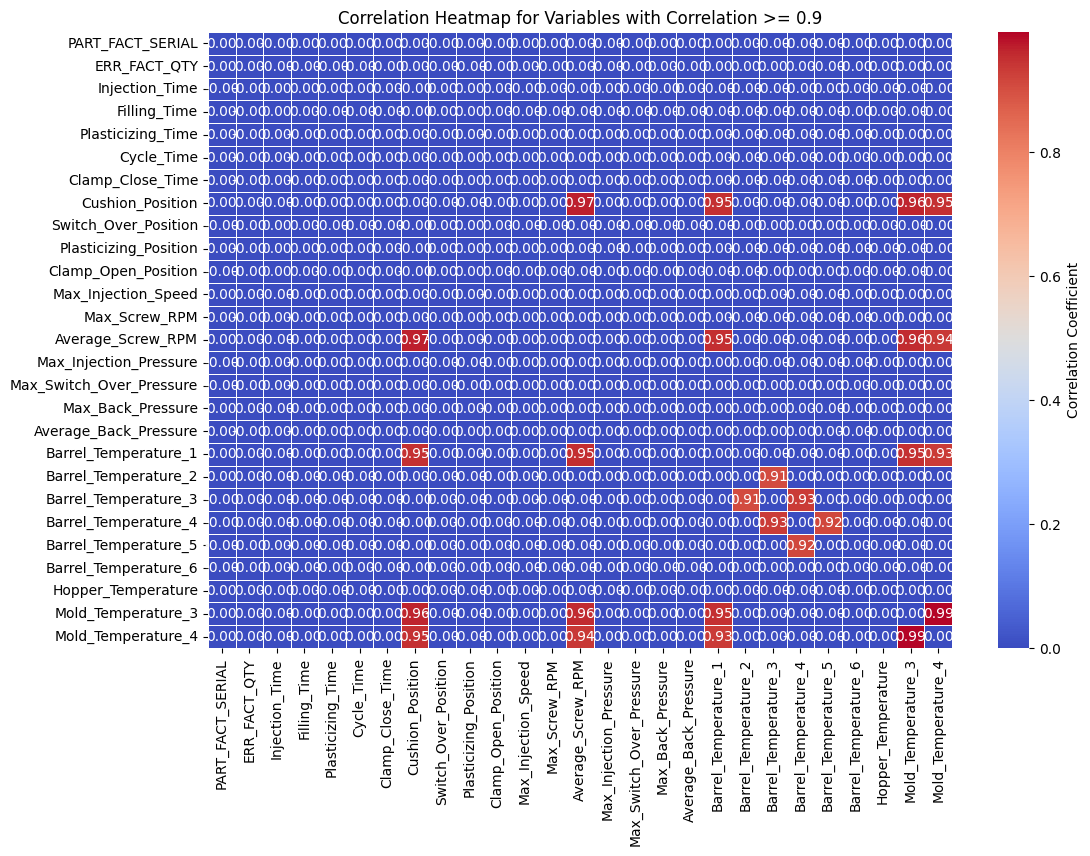

In [75]:
# 전체 상관 행렬 계산
correlation_matrix = unlabeled_viz.select_dtypes(include=np.number).corr()

# 상관계수가 0.9 이상인 변수들의 인덱스를 추출
high_corr_mask = (correlation_matrix >= 0.9) & (correlation_matrix != 1)  # 자기 자신 제외

# 높은 상관관계를 가진 변수들만 포함하는 상관 행렬 생성
high_corr_matrix = correlation_matrix * high_corr_mask

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Heatmap for Variables with Correlation >= 0.9")
plt.show()

In [54]:
# 상관계수 계산
correlation_matrix = train_ft.select_dtypes(include=np.number).corr()

# 상관관계가 높은 변수 쌍 필터링
threshold = 0.9  # 상관계수 임계값
high_corr_pairs = (
    correlation_matrix.unstack()
    .reset_index()  # 인덱스 정리
    .rename(columns={0: "correlation"})  # 상관계수 컬럼 이름 설정
)

# 자기 자신과의 상관관계 제거 및 중복 제거
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs["correlation"] >= threshold) &  # 임계값 이상
    (high_corr_pairs["level_0"] != high_corr_pairs["level_1"])  # 자기 자신 제외
].drop_duplicates(subset=["correlation"])  # 중복 제거

# 상관계수 내림차순 정렬
high_corr_pairs_sorted = high_corr_pairs.sort_values(by="correlation", ascending=False)

# 정렬된 결과 출력
print(high_corr_pairs_sorted)

                    level_0                   level_1  correlation
305   Plasticizing_Position       Clamp_Open_Position     0.999036
88             Filling_Time  Max_Switch_Over_Pressure     0.998543
82             Filling_Time     Plasticizing_Position     0.998020
310   Plasticizing_Position  Max_Switch_Over_Pressure     0.997616
39           Injection_Time              Filling_Time     0.997538
83             Filling_Time       Clamp_Open_Position     0.996204
347     Clamp_Open_Position  Max_Switch_Over_Pressure     0.996061
51           Injection_Time  Max_Switch_Over_Pressure     0.996009
45           Injection_Time     Plasticizing_Position     0.995093
685    Barrel_Temperature_2      Barrel_Temperature_3     0.994122
154              Cycle_Time          Cushion_Position     0.992923
648    Barrel_Temperature_1      Barrel_Temperature_3     0.992712
40           Injection_Time         Plasticizing_Time     0.991851
46           Injection_Time       Clamp_Open_Position     0.99

In [56]:
# 상관계수 계산
correlation_matrix = train_ft.select_dtypes(include=np.number).corr()

# 상관관계가 낮은 변수 쌍 필터링
threshold = 0  # 상관계수 임계값
low_corr_pairs = (
    correlation_matrix.unstack()
    .reset_index()  # 인덱스 정리
    .rename(columns={0: "correlation"})  # 상관계수 컬럼 이름 설정
)

# 자기 자신과의 상관관계 제거 및 중복 제거
low_corr_pairs = low_corr_pairs[
    (low_corr_pairs["correlation"] < threshold) &  # 임계값 미만
    (low_corr_pairs["level_0"] != low_corr_pairs["level_1"])  # 자기 자신 제외
].drop_duplicates(subset=["correlation"])  # 중복 제거

# 상관계수 오름차순 정렬
low_corr_pairs_sorted = low_corr_pairs.sort_values(by="correlation", ascending=True)

# 정렬된 결과 출력
print(low_corr_pairs_sorted)

                   level_0                   level_1  correlation
47          Injection_Time       Max_Injection_Speed    -0.999079
84            Filling_Time       Max_Injection_Speed    -0.999020
384    Max_Injection_Speed  Max_Switch_Over_Pressure    -0.998149
306  Plasticizing_Position       Max_Injection_Speed    -0.998087
343    Clamp_Open_Position       Max_Injection_Speed    -0.995666
..                     ...                       ...          ...
620  Average_Back_Pressure        Mold_Temperature_4    -0.018752
7         PART_FACT_SERIAL      Switch_Over_Position    -0.013450
139      Plasticizing_Time        Mold_Temperature_4    -0.011282
420          Max_Screw_RPM    Max_Injection_Pressure    -0.010503
283   Switch_Over_Position        Hopper_Temperature    -0.008179

[152 rows x 3 columns]


<Figure size 2000x2000 with 0 Axes>

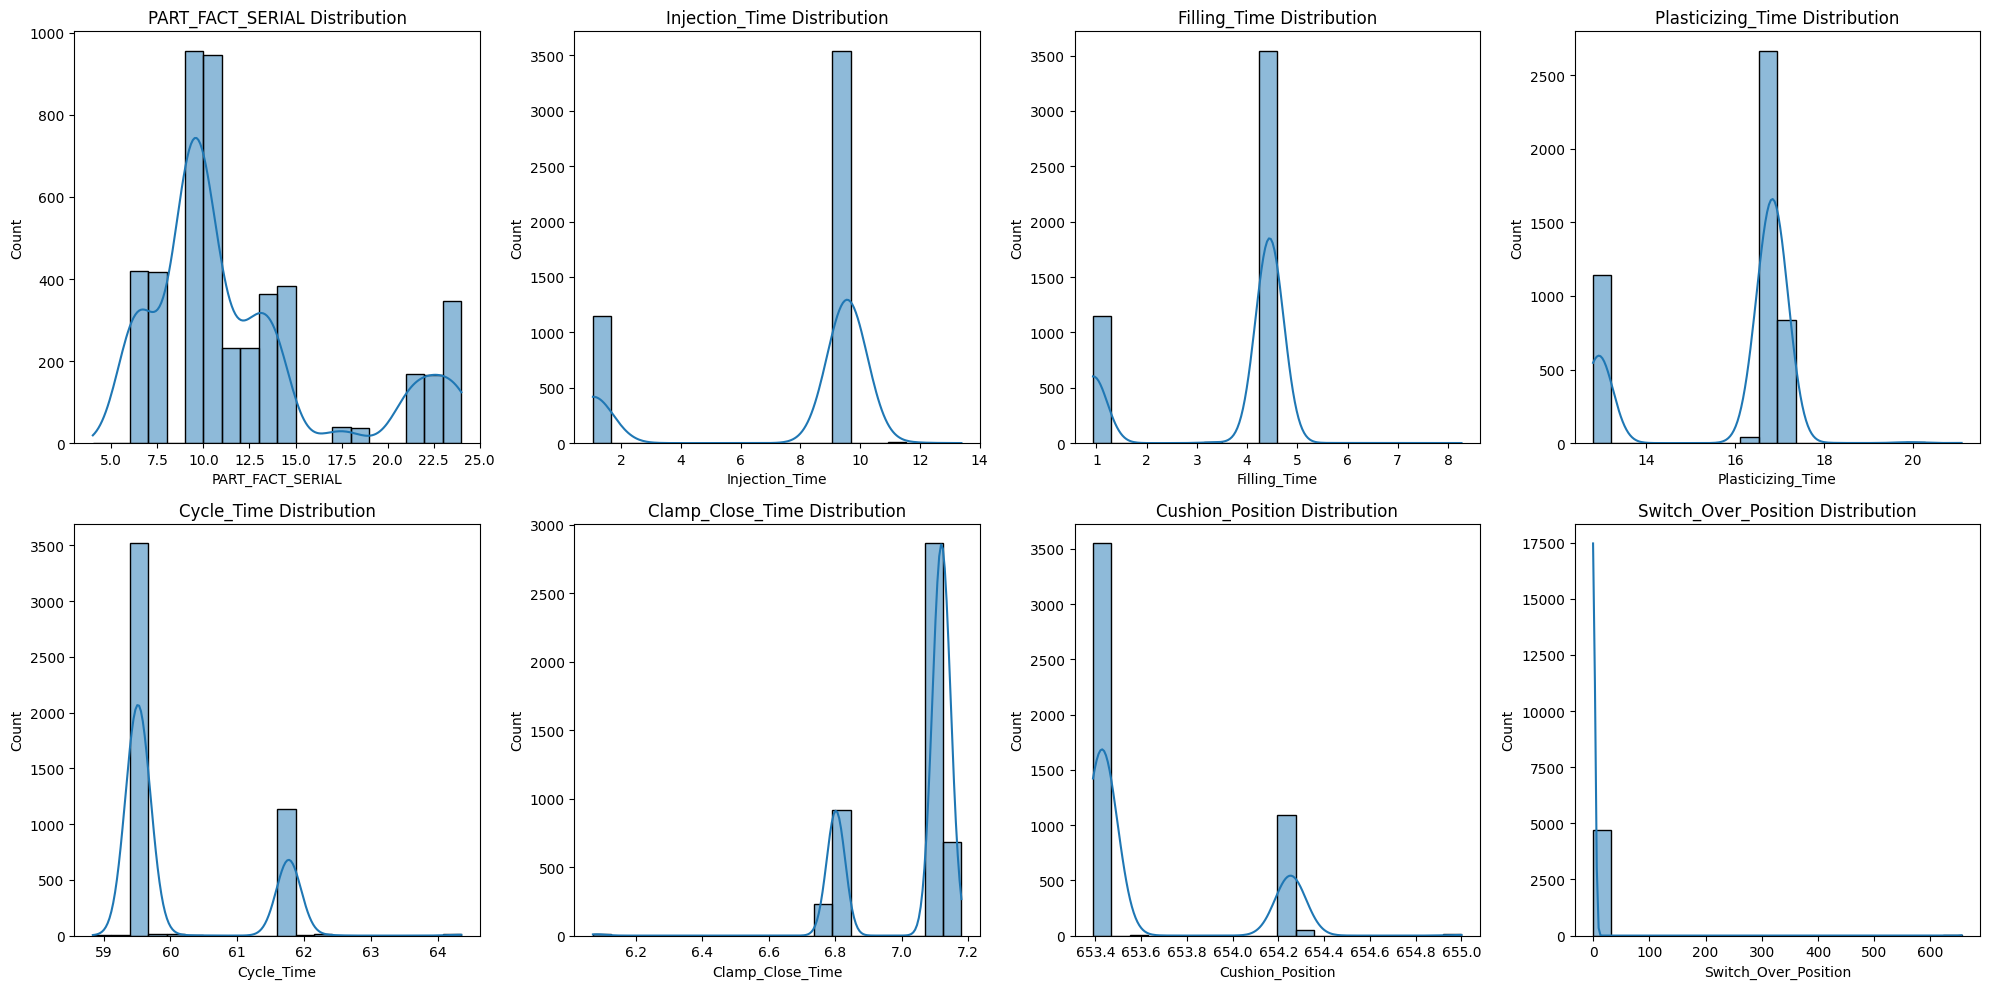

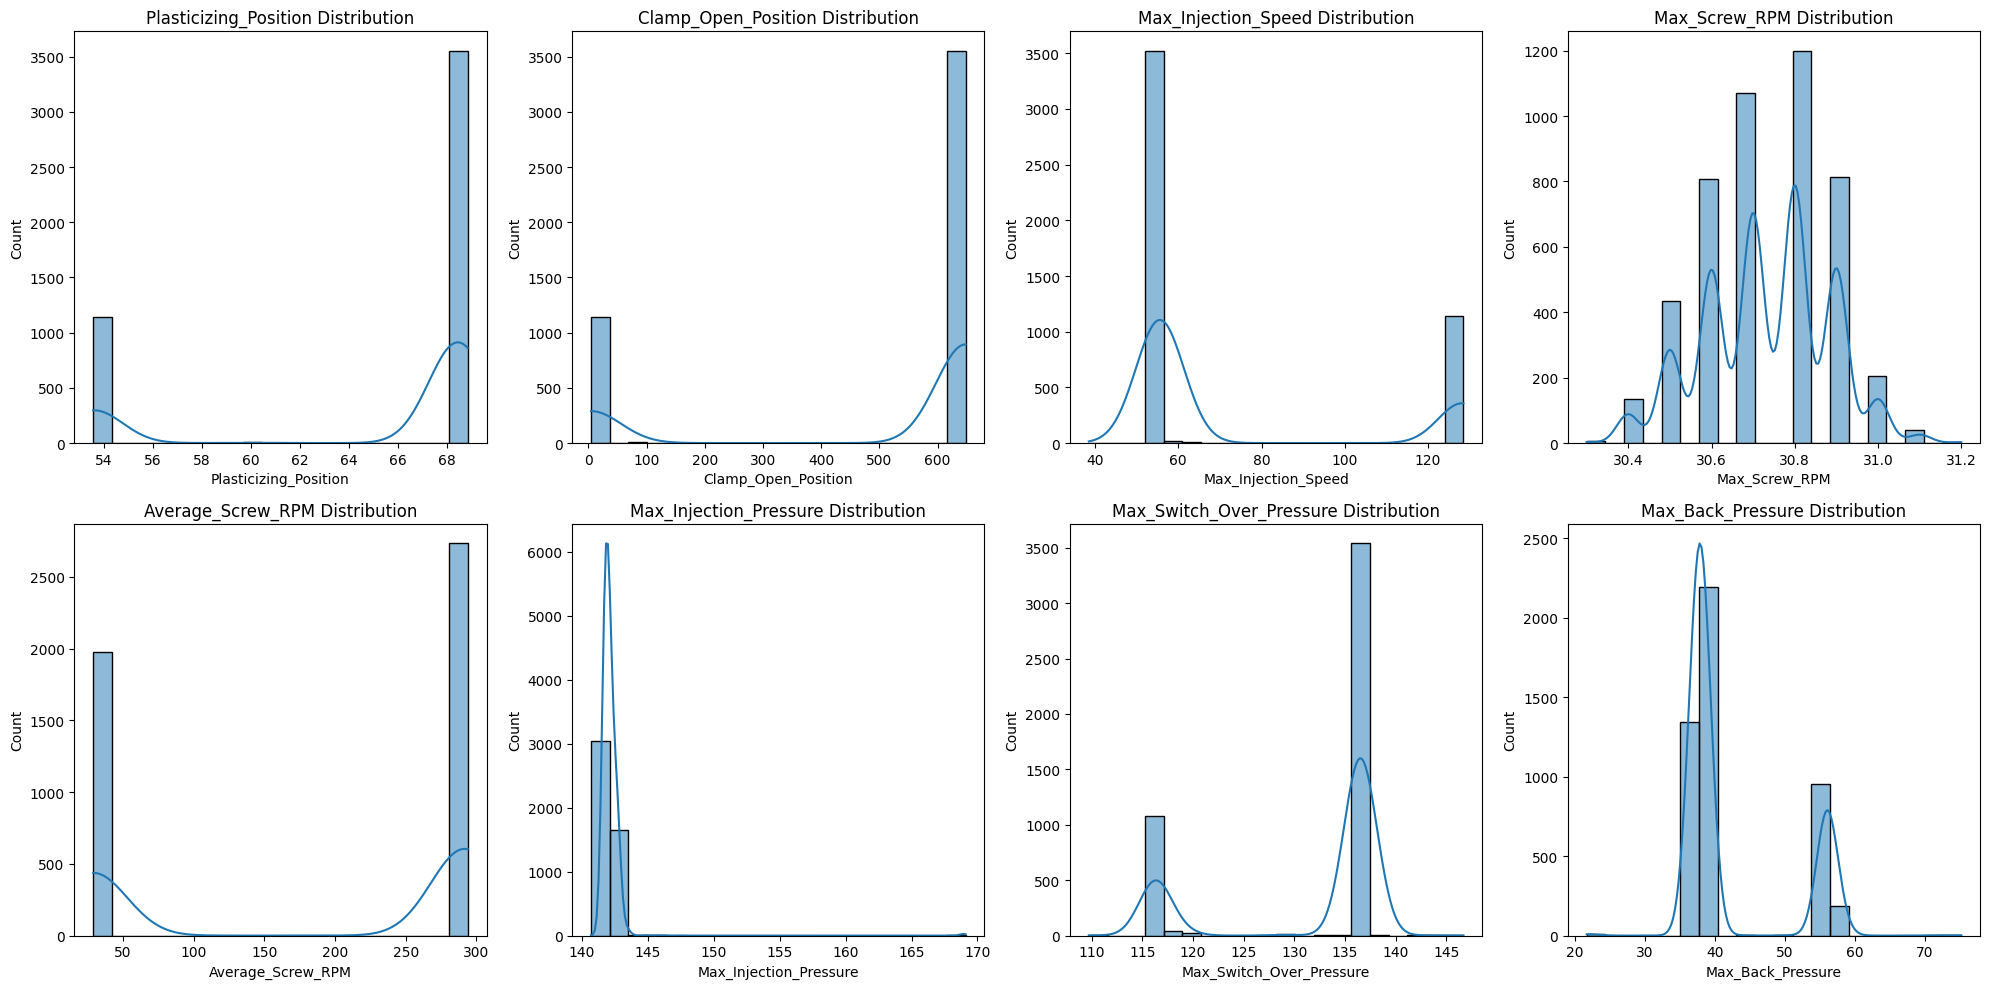

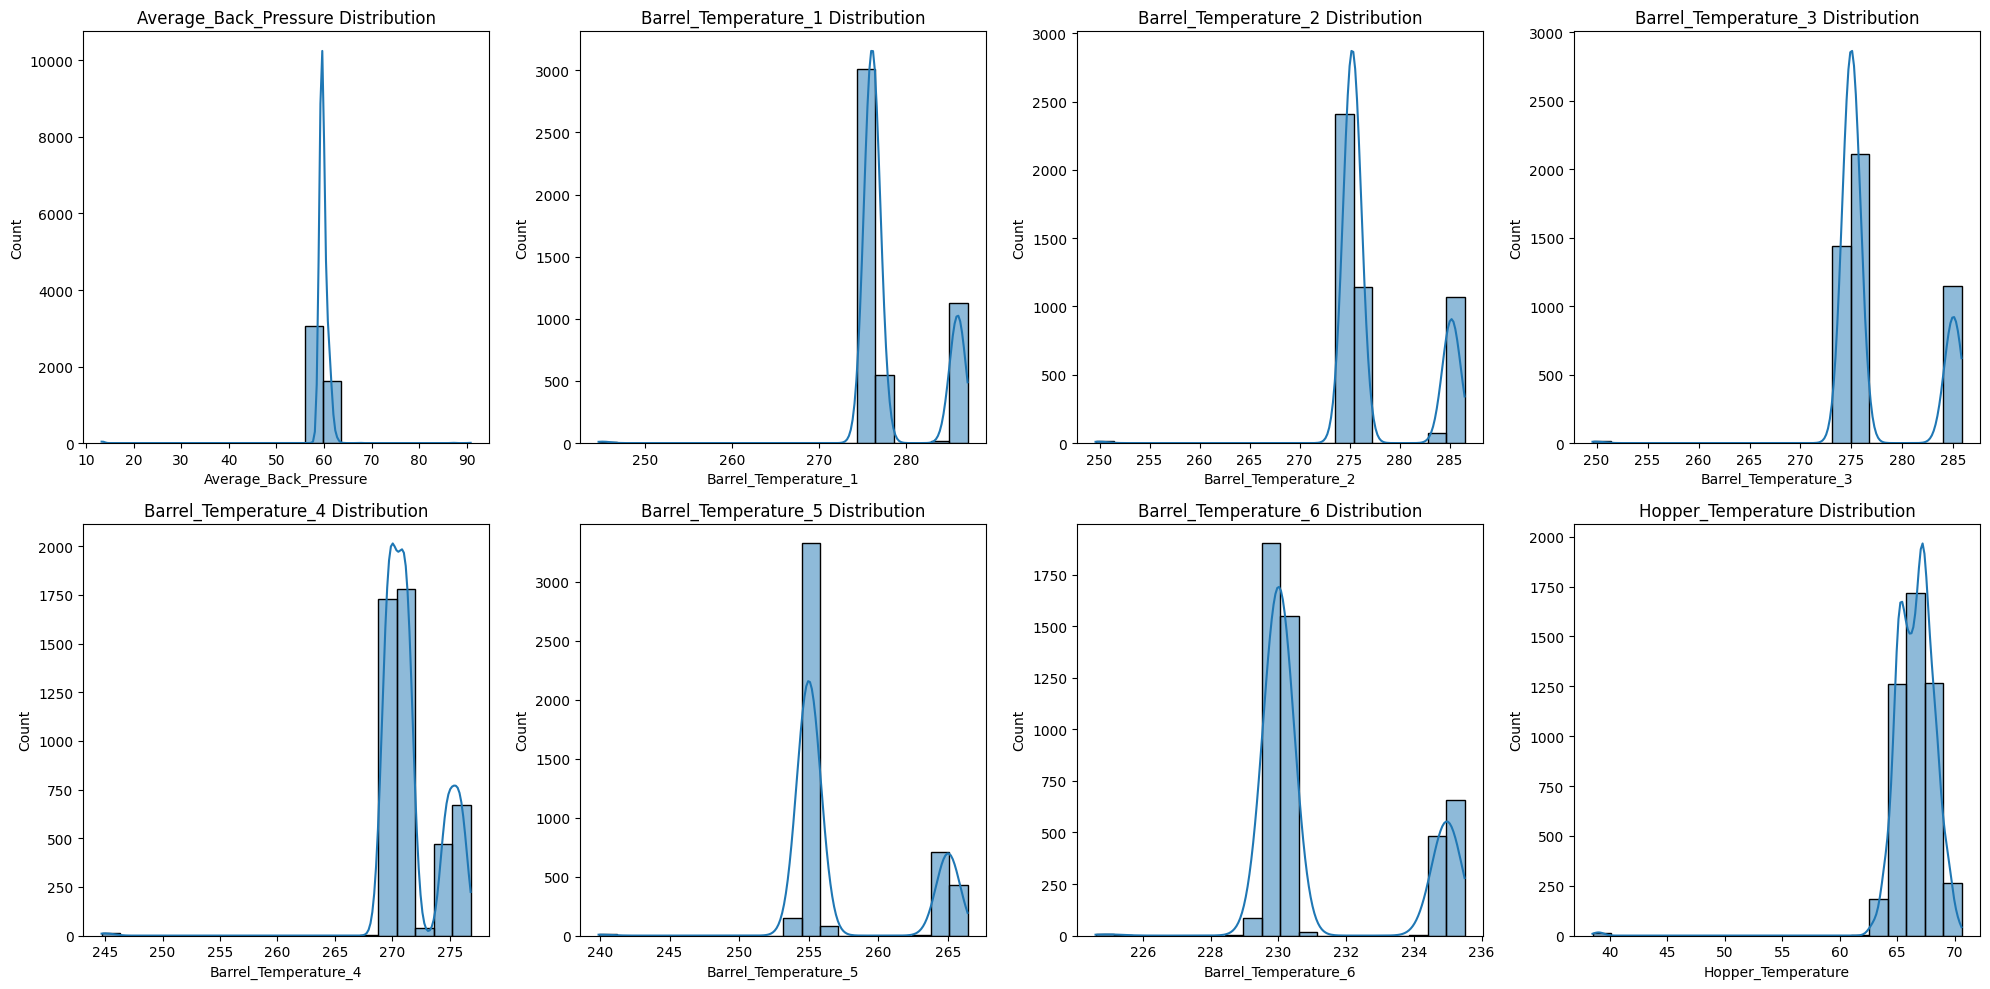

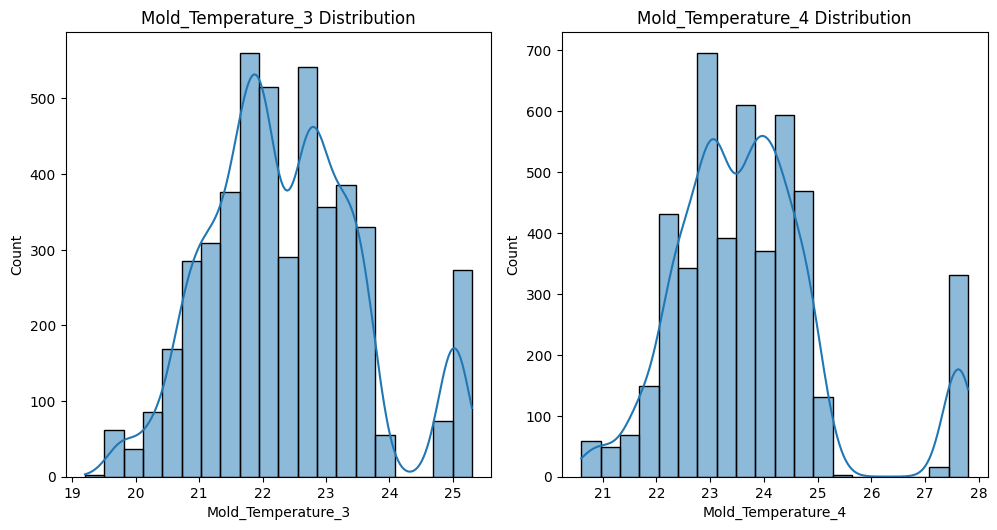

In [86]:
# 수치형 컬럼만 선택
numeric_cols = train_viz.select_dtypes(include=np.number).columns

# 히스토그램 시각화를 위한 설정
plt.figure(figsize=(20, 20))  # 그림 크기 설정

# 21개의 컬럼을 8개씩 나누어 시각화
num_cols = len(numeric_cols)
cols_per_plot = 8  # 한 plot에 출력할 수치형 변수 수
num_plots = (num_cols // cols_per_plot) + (1 if num_cols % cols_per_plot > 0 else 0)

# 히스토그램을 여러 번에 걸쳐 그리기
for plot_idx in range(num_plots):
    start_idx = plot_idx * cols_per_plot
    end_idx = min(start_idx + cols_per_plot, num_cols)

    plt.figure(figsize=(20, 10))  # 각 subplot을 위한 새로운 figure 설정
    for i, col in enumerate(numeric_cols[start_idx:end_idx], 1):
        plt.subplot(2, 4, i)  # 2행 4열로 subplot 배치
        sns.histplot(train_ft[col], kde=True, bins=20)  # 히스토그램 + 커널 밀도 추정(KDE)
        plt.title(f'{col} Distribution')  # 각 변수 이름을 제목으로 추가
        plt.tight_layout()  # 레이아웃 간격 자동 조정

    plt.show()

<Figure size 2000x2000 with 0 Axes>

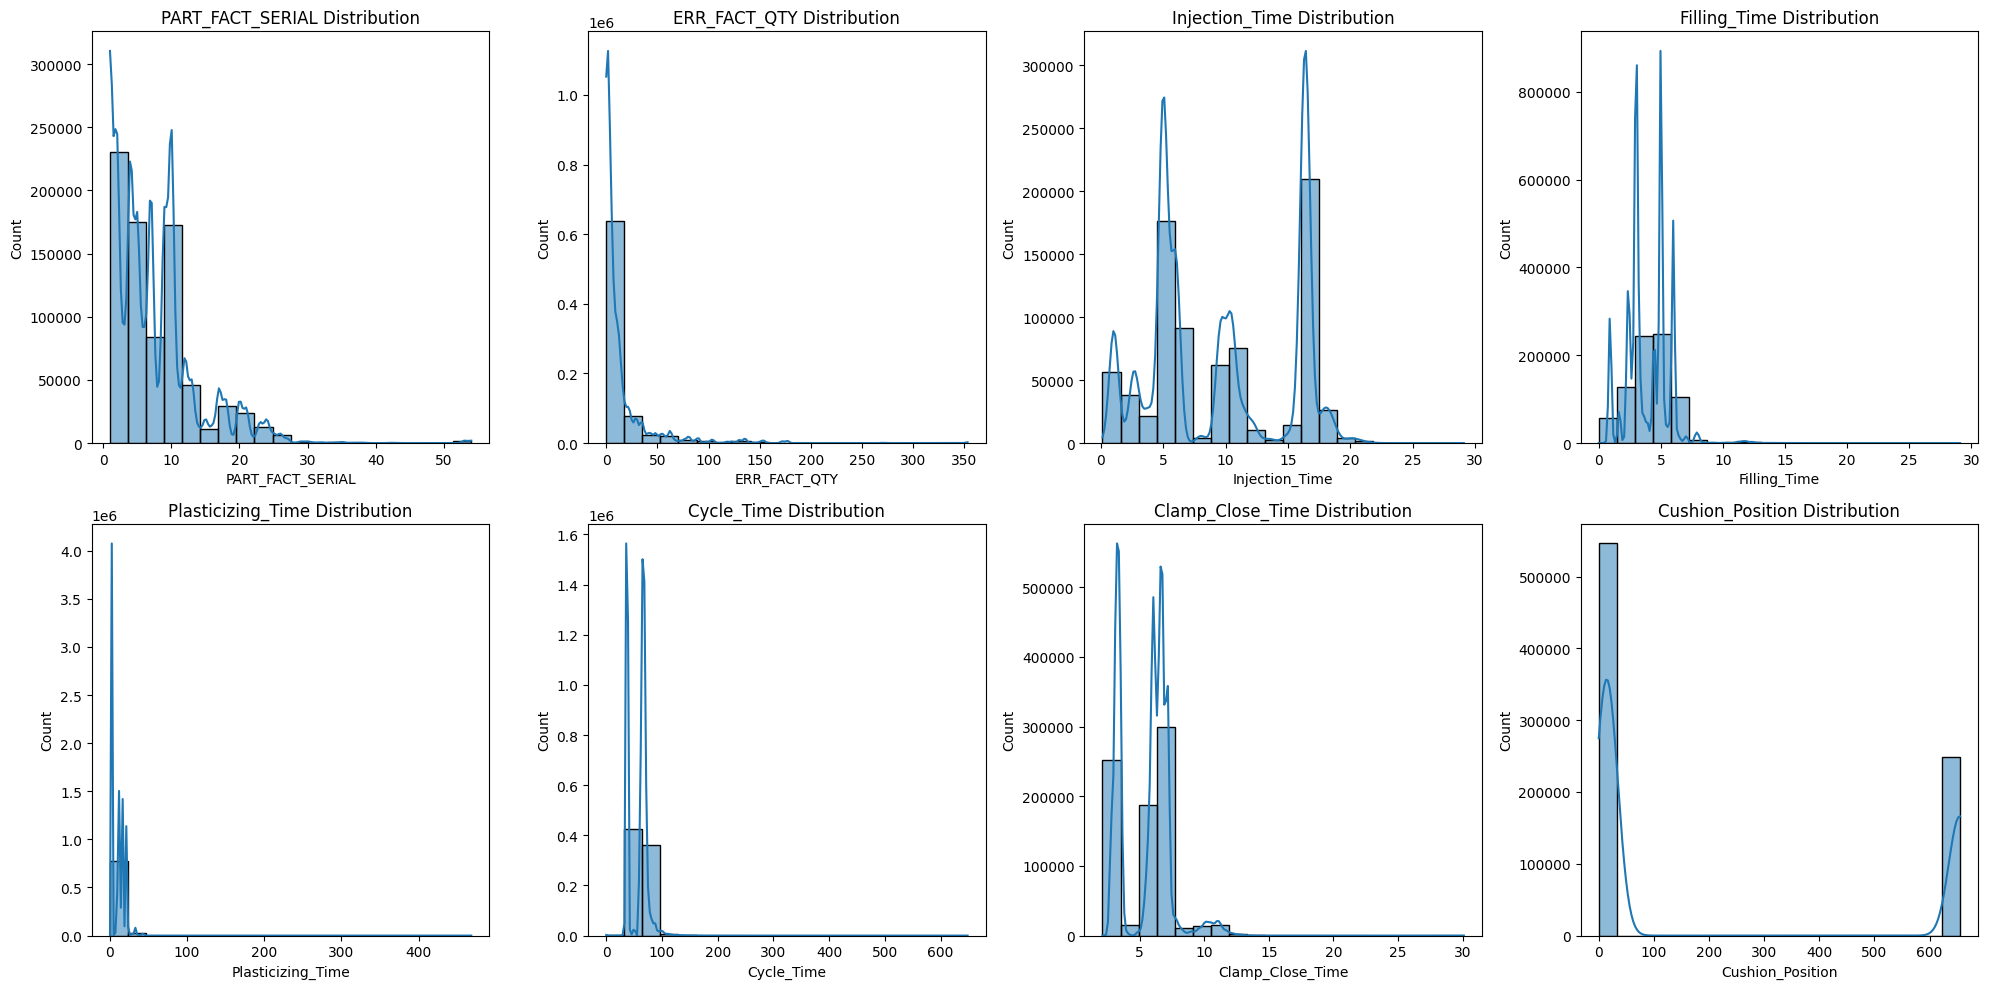

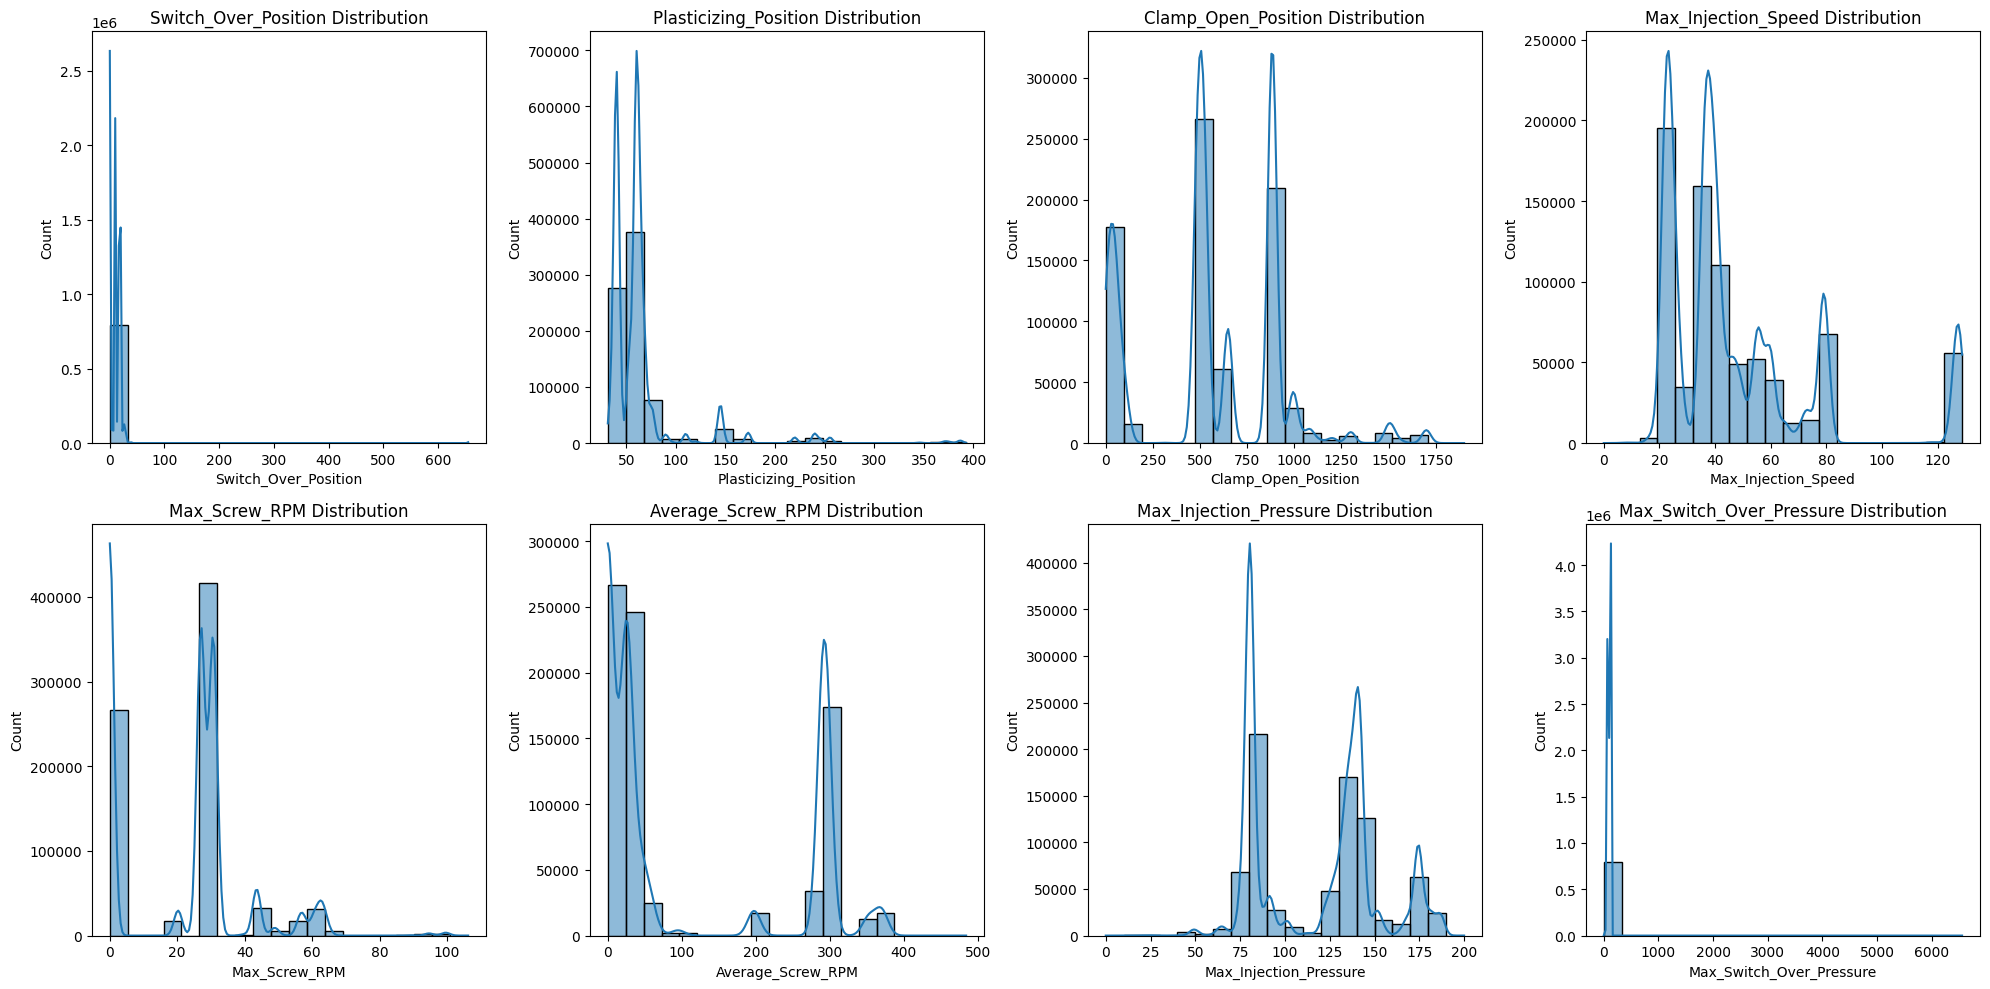

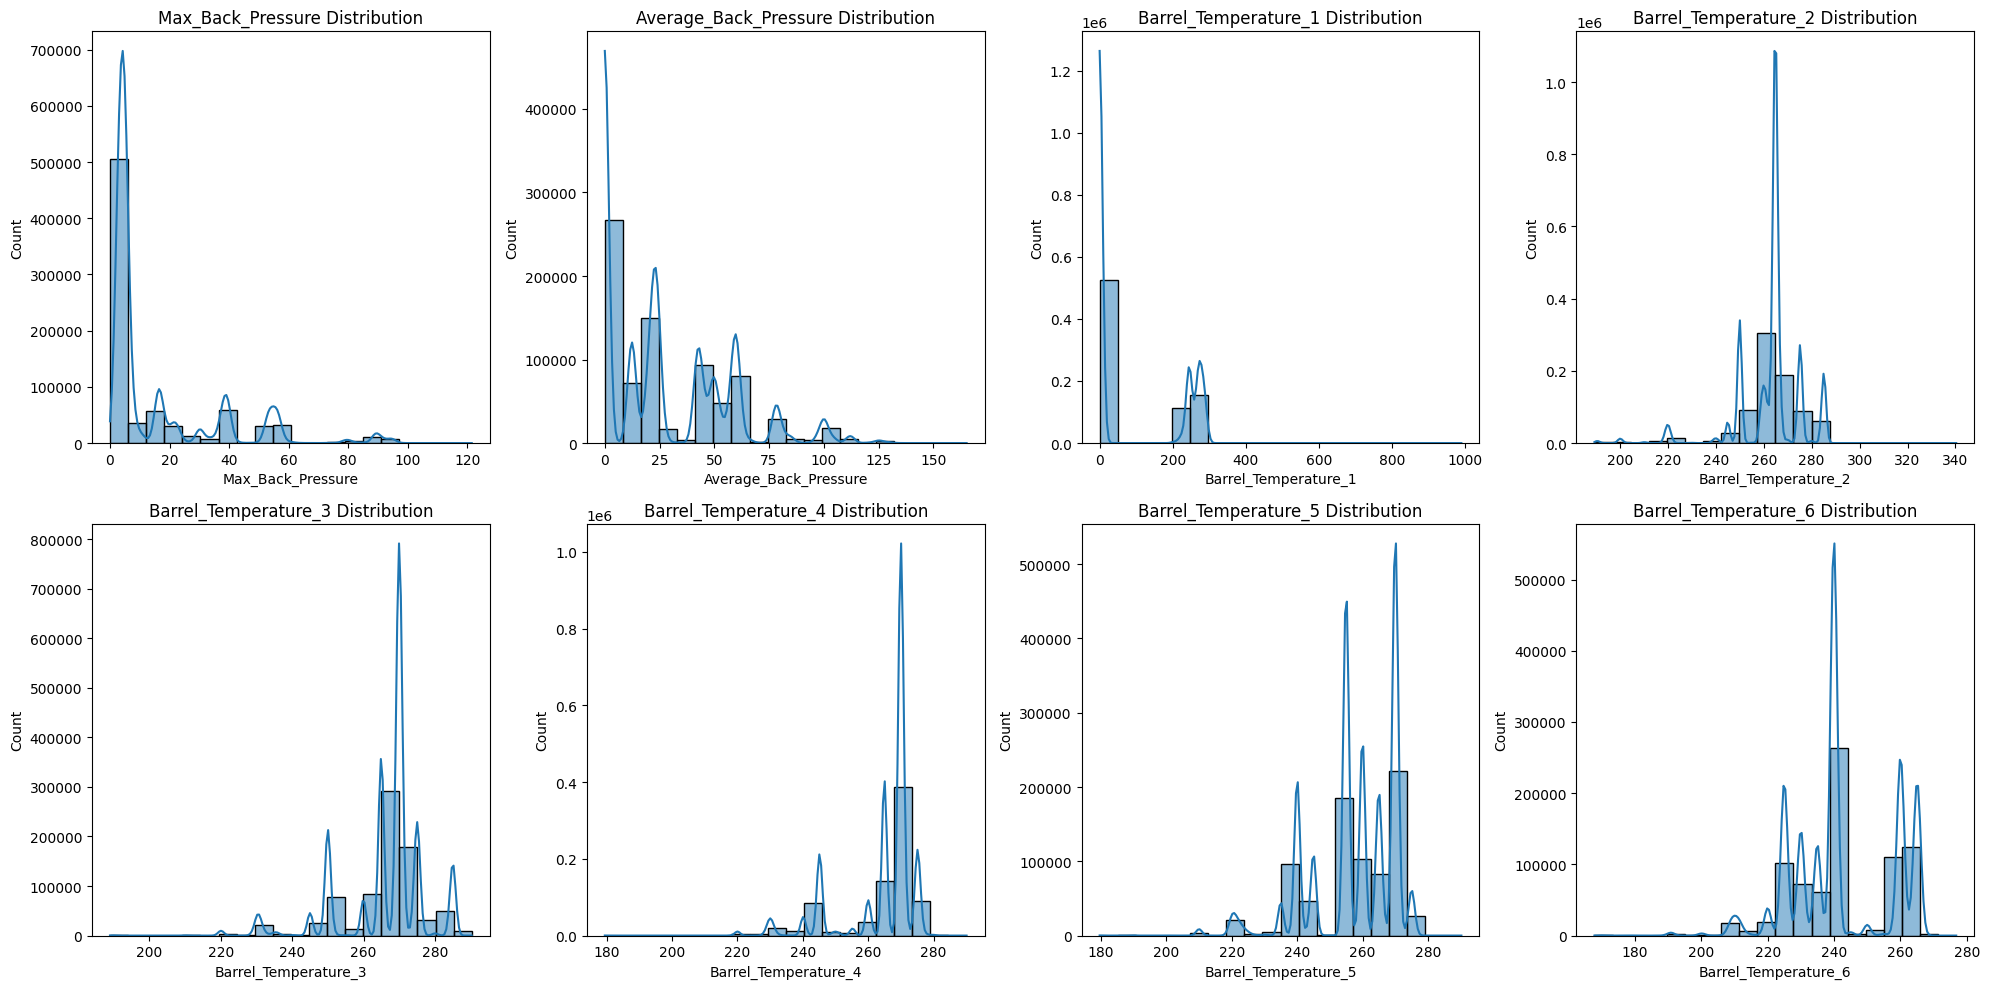

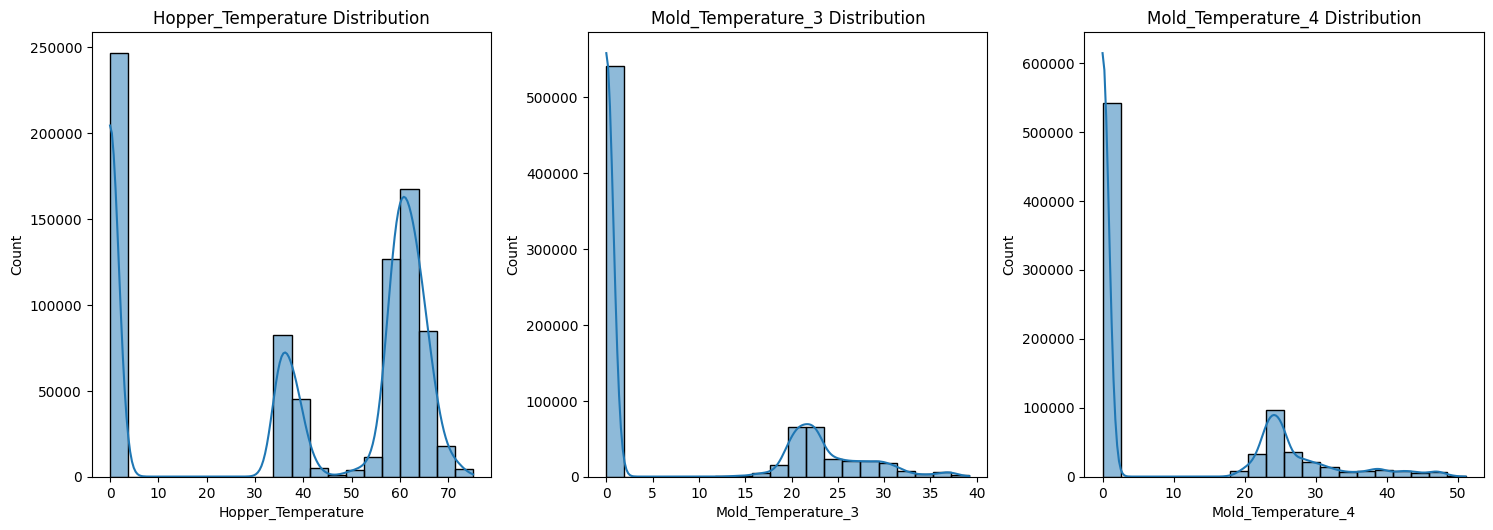

In [87]:
# 수치형 컬럼만 선택
numeric_cols = unlabeled_viz.select_dtypes(include=np.number).columns

# 히스토그램 시각화를 위한 설정
plt.figure(figsize=(20, 20))  # 그림 크기 설정

# 21개의 컬럼을 8개씩 나누어 시각화
num_cols = len(numeric_cols)
cols_per_plot = 8  # 한 plot에 출력할 수치형 변수 수
num_plots = (num_cols // cols_per_plot) + (1 if num_cols % cols_per_plot > 0 else 0)

# 히스토그램을 여러 번에 걸쳐 그리기
for plot_idx in range(num_plots):
    start_idx = plot_idx * cols_per_plot
    end_idx = min(start_idx + cols_per_plot, num_cols)

    plt.figure(figsize=(20, 10))  # 각 subplot을 위한 새로운 figure 설정
    for i, col in enumerate(numeric_cols[start_idx:end_idx], 1):
        plt.subplot(2, 4, i)  # 2행 4열로 subplot 배치
        sns.histplot(unlabeled[col], kde=True, bins=20)  # 히스토그램 + 커널 밀도 추정(KDE)
        plt.title(f'{col} Distribution')  # 각 변수 이름을 제목으로 추가
        plt.tight_layout()  # 레이아웃 간격 자동 조정

    plt.show()

- Labeled 와 Unlabeled 둘 다 동일하게 Mold_Temperature_3, Mold_Temperature_4 제외한 나머지 값은 0임
- Unlabeled의 Mold_Temperature_3, Mold_Temperature_4 분포는 Labeled보다 왼쪽으로 많이 치우침
- Labeled의 Barrel_Temperature_7의 값은 0 이었지만 Unlabeled 에서는 값이 존재
- 대체적으로 Labeled과Unlabeled의 컬럼들 값 분포가 다른 모습을 보임
    - 아무래도 Unlabeled 데이터가 많다보니? + 기간도 다름